In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np

Let's load the MNIST data set.

In [2]:
mnist = keras.datasets.mnist
(imgs, labels), (test_imgs, test_labels) = mnist.load_data()
len(imgs)

60000

Here are the binary examples where the labels are either $0$ or $1$.

In [3]:
i01 = [i for i in range(len(labels)) if (labels[i]==0) or (labels[i]==1)]
imgs01 = imgs[i01]
labels01 = labels[i01]

Our goal is to find a function $\hat{f}:\mathbb{R}^d\to \mathbb{R}$ such that for our examples $\{(\mathbf{x}_i,y_i): i = 1,\dotsm,n\}$ such that $\hat{f}(\mathbf{x}_i)\approx y_i$ for all $i$.

This is a problem of binary classification (we are only restricting to $0$ and $1$s) there is a natural way that we can approach this **supervised learning** problem. (It is **supervised** because we know the correct labels).

This will seem similar to the linear regression problem:

1) We define a class of functions $\widehat{\mathcal{F}}$ (a collection of classifiers)

2) We define a loss function $\ell(\hat{f},(\mathbf{x},y))$ which quantifies how close $\hat{f}(\mathbf{x})$ is to $y$.

We then want to find a function $\hat{f}$ which minimizes the average loss:
$$
\frac{1}{n} \sum_{i=1}^n \ell\left(\hat{f},(\mathbf{x}_i,y_i)\right).
$$

One example is *logistic regression* where we consider the classifiers of the form
$$
\hat{f}(\mathbf{x}) = \sigma\left(\mathbf{x}^T\boldsymbol{\theta}\right) \qquad \sigma(t) = \frac{1}{1+e^{-t}}
$$
where $\boldsymbol{\theta}\in\mathbb R^d$ is a parameter.

Note that $\sigma(5) \approx 6.7\times 10^{-3}$ and $\sigma(-5) \approx 0.993$.

We then use the cross-entropy loss (common with logistic regression)
$$
\ell\left(\hat{f},(\mathbf{x},y)\right) = -y\log(\sigma(\mathbf{x}^T\boldsymbol{\theta})) - (1-y) \log(1-\sigma(\mathbf{x}^T\boldsymbol{\theta})).
$$

We then want to minimize
$$
\min_{\boldsymbol{\theta}\in\mathbb R^d} - \sum_{i=1}^n y_i\log\left(\sigma\left(\mathbf{x}_i^T\boldsymbol{\theta}\right)\right) + (1-y) \log\left(1-\sigma\left(\mathbf{x}_i^T\boldsymbol{\theta}\right)\right).
$$

We now want to minimize this function:
$$
F(\boldsymbol{\theta}) = -\frac{1}{n}\sum_{i=1}^n\left( y_i \log (\sigma(\mathbf{x}_i^T\boldsymbol{\theta})) + (1-y_i) \log (1-\sigma(\mathbf{x}_i^T\boldsymbol{\theta}))\right)
$$so let's look at its gradient. First note that 
$$
\sigma'(t) = \frac{e^{-t}}{(1+e^{-t})^2} = \frac{1}{1+e^{-t}} \frac{e^{-t}}{1+e^{-t}} = \sigma(t) (1-\sigma(t)).
$$ Therefore
$$
\frac{d}{dt} \log(\sigma(t)) = \frac{1}{\sigma(t)} \sigma'(t) = 1-\sigma(t)
$$
Similarly
$$
\frac{d}{dt} \log(1-\sigma(t)) = \frac{1}{1-\sigma(t)} (-\sigma'(t)) = -\sigma(t).
$$

So
$$
\frac{d}{dt} -\left( y \log (\sigma(t)) + (1-y)\log(1-\sigma(t))\right) = y(\sigma(t)-1) + (1-y)\sigma(t) = \sigma(t)-y.
$$

We can now compute the gradient of $F$ using the chain rule:
$$
\nabla F (\boldsymbol{\theta}) = -\frac{1}{n}\sum_{p=1}^n \left(y_p - \sigma(\mathbf{x}_p^T\boldsymbol{\theta})  \right)\mathbf{x}_p
$$

Let's look the $i$th entry of this gradient:
$$
\partial_{\theta_i} F =-\frac{1}{n} \sum_{p=1}^n (\mathbf{x}_p)_i (y_p - \sigma(\mathbf{x}_p^T\boldsymbol{\theta})) .
$$

We can then see that
$$
\partial_{\theta_j}\partial_{\theta_i} F= \frac{1}{n} \sum_{p=1}^n (\mathbf{x}_p)_i (-\sigma'(\mathbf{x}_p^T \boldsymbol{\theta})) (\mathbf{x}_p)_j = \frac{1}{n}\sum_{p=1}^n \sigma(\mathbf{x}_p^T \boldsymbol{\theta})(1-\sigma(\mathbf{x}_p^T \boldsymbol{\theta})) (\mathbf{x}_p)_i (\mathbf{x}_p)_j.
$$

But $\mathbf{v}_i \mathbf{u}_j$ is the $ij$th entry in the matrix $\mathbf{v} \mathbf{u}^T$ and so we can write the above as a matrix via
$$
H_F(\boldsymbol{\theta}) = \frac{1}{n}\sum_{p=1}^n \sigma(\mathbf{x}_p^T \boldsymbol{\theta})(1-\sigma(\mathbf{x}_p^T \boldsymbol{\theta})) \mathbf{x}_p \mathbf{x}_p^T.
$$

In [70]:
X = np.vstack([imgs01[i].flatten() for i in range(len(labels01))])
y = labels01
X = X[:100]
y = y[:100]

In [72]:
nozeroSpots = []
for j in range(len(X[0,:])):
    if np.sum(X[:,j])!=0:
        nozeroSpots.append(j)
X = X[:,nozeroSpots]
Z = np.zeros((100,19))
for j in range(19):
    for i in range(100):
        x = [X[i,k] for k in range(418) if np.mod(k,22)==j]
        Z[i,j] = np.mean(x)/256
X = Z

In [80]:
import random
random.seed(100)
param = [1 for j in range(np.shape(X)[1])]

In [81]:
def sigma(t):
    return np.double(1/(1+np.exp(-t)))
def grad(X,y,param):
    N = len(y)
    gr = np.zeros(len(X[0,:]))
    for j in range(N):
        gr = gr - N**(-1)*(y[j]-sigma(np.matmul(X[j,:],param)))*X[j,:]
    return gr
def loss(X,y,param):
    lval = 0
    N = len(y)
    for j in range(N):
        if y[j] == 0:
            lval = lval - ((1-y[j])*np.log(1-sigma(np.matmul(X[j,:],param))))
        else: 
            lval = lval - y[j]*np.log(sigma(np.matmul(X[j,:],param)))
    return lval

We can now try to implement gradient descent. By a lemma in the notes, we can bound the Hessian's largest eigenvalue by
$$
\lambda_1(H_F(\boldsymbol{\theta})) \le \frac{1}{n}\sum_{i=1}^n \|\mathbf{x}\|_2^2.
$$

In [82]:
N = 100
L = np.linalg.norm(X)**2/N
iteration = 10000

In [83]:
losses = [loss(X,y,param)]
for i in range(iteration):
    param = param-grad(X,y,param)/L
    losses.append(loss(X,y,param))

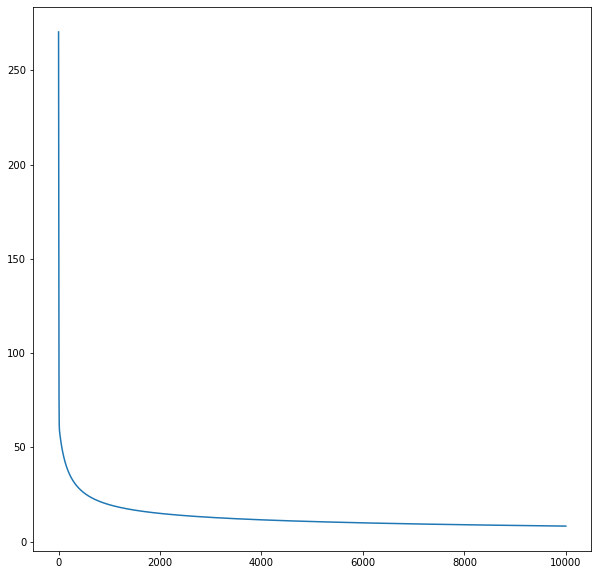

In [84]:
plt.figure(figsize = (10,10))
plt.plot([t for t in range(len(losses))],losses)

In [85]:
for i in range(10):
    print(y[i] , sigma(np.matmul(X[i,:],param)))

0 0.0009297624929990132
1 0.9803182376554032
1 0.999935822158158
1 0.9936350470898442
1 0.9403444566354474
0 0.00014407184346473885
1 0.9695991361255856
1 0.9991056586072061
0 0.7362179868735731
0 0.00038164270181153685
